In [1]:
from project import data_frames

for key, values in data_frames.items():
    print(key)

energy-data/power-laws-forecasting-energy-consumption-holidays.csv
energy-data/power-laws-forecasting-energy-consumption-metadata.csv
energy-data/power-laws-forecasting-energy-consumption-submission-forecast-period.csv
energy-data/power-laws-forecasting-energy-consumption-test-data.csv
energy-data/power-laws-forecasting-energy-consumption-training-data.csv
energy-data/power-laws-forecasting-energy-consumption-weather.csv


# Proyecto Minería


# Clustering

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!sudo apt-get install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import Imputer


In [4]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

23/10/14 16:28:04 WARN Utils: Your hostname, codespaces-f5d2da resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
23/10/14 16:28:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/14 16:28:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
holidays = data_frames['energy-data/power-laws-forecasting-energy-consumption-holidays.csv']
metadata = data_frames['energy-data/power-laws-forecasting-energy-consumption-metadata.csv']
forecast = data_frames['energy-data/power-laws-forecasting-energy-consumption-submission-forecast-period.csv']
test_data = data_frames['energy-data/power-laws-forecasting-energy-consumption-test-data.csv']
train_data = data_frames['energy-data/power-laws-forecasting-energy-consumption-training-data.csv']
weather = data_frames['energy-data/power-laws-forecasting-energy-consumption-weather.csv']

In [6]:
total_data = pd.concat([train_data, test_data])

In [7]:
# Convert the Timestamp column to datetime
total_data['Timestamp'] = pd.to_datetime(total_data['Timestamp'])

# Group by Timestamp and SiteId, and calculate the mean value
result_total_data = total_data.groupby(['SiteId', pd.Grouper(key='Timestamp', freq='H')])['Value'].mean().reset_index()

result_total_data

,SiteId,Timestamp,Value
0,1,2014-09-03 00:00:00+00:00,9.096555e+05
1,1,2014-09-04 00:00:00+00:00,1.748273e+06
2,1,2014-09-05 00:00:00+00:00,NaN
3,1,2014-09-06 00:00:00+00:00,NaN
4,1,2014-09-07 00:00:00+00:00,NaN
...,...,...,...
3149111,305,2015-11-21 08:00:00+00:00,2.146361e+03
3149112,305,2015-11-21 09:00:00+00:00,4.210141e+03
3149113,305,2015-11-21 10:00:00+00:00,3.944624e+03
3149114,305,2015-11-21 11:00:00+00:00,3.981655e+03


### Se organizan los datos en orden cronologico

In [8]:
data_spark = spark.createDataFrame(result_total_data)

/home/codespace/.python/current/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:
/home/codespace/.python/current/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


In [9]:
data_ordenado=data_spark.sort('Timestamp')

In [10]:
data_spark.show()

23/10/14 16:30:29 WARN TaskSetManager: Stage 0 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:30:34 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


+------+-------------------+------------------+
|SiteId|          Timestamp|             Value|
+------+-------------------+------------------+
|     1|2014-09-03 00:00:00|  909655.510515214|
|     1|2014-09-04 00:00:00| 1748273.124752296|
|     1|2014-09-05 00:00:00|               NaN|
|     1|2014-09-06 00:00:00|               NaN|
|     1|2014-09-07 00:00:00|               NaN|
|     1|2014-09-08 00:00:00|  1964877.99902387|
|     1|2014-09-09 00:00:00|  3266903.91769804|
|     1|2014-09-10 00:00:00|2926094.4745757496|
|     1|2014-09-11 00:00:00|1720502.1513768754|
|     1|2014-09-12 00:00:00|1136248.1075743749|
|     1|2014-09-13 00:00:00|1040528.6001987156|
|     1|2014-09-14 00:00:00|1030667.6855087331|
|     1|2014-09-15 00:00:00|1226753.4244866522|
|     1|2014-09-16 00:00:00|1228874.2899190905|
|     1|2014-09-17 00:00:00|  1169026.41570396|
|     1|2014-09-18 00:00:00|1513721.7344672228|
|     1|2014-09-19 00:00:00|2015528.3234096123|
|     1|2014-09-20 00:00:00|2548942.6232

In [11]:
data_ordenado.show()

23/10/14 16:30:35 WARN TaskSetManager: Stage 1 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


+------+-------------------+-----------------+
|SiteId|          Timestamp|            Value|
+------+-------------------+-----------------+
|   297|2009-06-23 06:00:00| 96408.8267305633|
|   297|2009-06-23 07:00:00|76800.25180231314|
|   297|2009-06-23 08:00:00|75166.20389162563|
|   297|2009-06-23 09:00:00| 71898.1080702506|
|   297|2009-06-23 10:00:00|73532.15598093811|
|   297|2009-06-23 11:00:00| 71898.1080702506|
|   297|2009-06-23 12:00:00| 71898.1080702506|
|   297|2009-06-23 13:00:00|70264.06015956309|
|   297|2009-06-23 14:00:00| 71898.1080702506|
|   297|2009-06-23 15:00:00| 71898.1080702506|
|   297|2009-06-23 16:00:00|70264.06015956309|
|   297|2009-06-23 17:00:00| 71898.1080702506|
|   297|2009-06-23 18:00:00| 71898.1080702506|
|   297|2009-06-23 19:00:00| 71898.1080702506|
|   297|2009-06-23 20:00:00|78434.29971300067|
|   297|2009-06-23 21:00:00|78434.29971300067|
|   297|2009-06-23 22:00:00|80068.34762368817|
|   297|2009-06-23 23:00:00|81702.39553437567|
|   297|2009-

In [12]:
# Convert the Timestamp column to datetime
weather['Timestamp'] = pd.to_datetime(weather['Timestamp'])

# Group by Timestamp and SiteId, and calculate the mean temperature
result = weather.groupby(['SiteId', pd.Grouper(key='Timestamp', freq='H')])['Temperature'].median().reset_index()

result

,SiteId,Timestamp,Temperature
0,2,2013-01-01 13:00:00+00:00,21.85
1,2,2013-01-01 14:00:00+00:00,22.00
2,2,2013-01-01 15:00:00+00:00,22.00
3,2,2013-01-01 16:00:00+00:00,22.70
4,2,2013-01-01 17:00:00+00:00,22.00
...,...,...,...
1284292,57,2017-12-30 18:00:00+00:00,8.00
1284293,57,2017-12-30 19:00:00+00:00,8.70
1284294,57,2017-12-30 20:00:00+00:00,8.00
1284295,57,2017-12-30 21:00:00+00:00,7.00


In [13]:
data_weatherpark = spark.createDataFrame(result)

/home/codespace/.python/current/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:
/home/codespace/.python/current/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


In [14]:
data_weatherorden=data_weatherpark.sort('Timestamp')

In [15]:
data_weatherpark.show()

+------+-------------------+-----------+
|SiteId|          Timestamp|Temperature|
+------+-------------------+-----------+
|     2|2013-01-01 13:00:00|      21.85|
|     2|2013-01-01 14:00:00|       22.0|
|     2|2013-01-01 15:00:00|       22.0|
|     2|2013-01-01 16:00:00|       22.7|
|     2|2013-01-01 17:00:00|       22.0|
|     2|2013-01-01 18:00:00|       22.0|
|     2|2013-01-01 19:00:00|      20.75|
|     2|2013-01-01 20:00:00|       20.0|
|     2|2013-01-01 21:00:00|       17.0|
|     2|2013-01-01 22:00:00|       16.0|
|     2|2013-01-01 23:00:00|       16.0|
|     2|2013-01-02 00:00:00|       15.0|
|     2|2013-01-02 01:00:00|       15.0|
|     2|2013-01-02 02:00:00|       15.0|
|     2|2013-01-02 03:00:00|       15.0|
|     2|2013-01-02 04:00:00|      13.95|
|     2|2013-01-02 05:00:00|       15.0|
|     2|2013-01-02 06:00:00|       15.0|
|     2|2013-01-02 07:00:00|      15.95|
|     2|2013-01-02 08:00:00|       17.0|
+------+-------------------+-----------+
only showing top

23/10/14 16:31:36 WARN TaskSetManager: Stage 2 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


In [16]:
data_weatherorden.show()

23/10/14 16:31:37 WARN TaskSetManager: Stage 3 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


+------+-------------------+-----------+
|SiteId|          Timestamp|Temperature|
+------+-------------------+-----------+
|     3|2013-01-01 13:00:00|      21.85|
|    10|2013-01-01 13:00:00|      25.85|
|     4|2013-01-01 13:00:00|      25.85|
|     2|2013-01-01 13:00:00|      21.85|
|     5|2013-01-01 13:00:00|      21.85|
|     6|2013-01-01 13:00:00|      21.85|
|     8|2013-01-01 13:00:00|      25.85|
|     9|2013-01-01 13:00:00|      25.85|
|    10|2013-01-01 14:00:00|       27.0|
|     4|2013-01-01 14:00:00|       27.0|
|     2|2013-01-01 14:00:00|       22.0|
|     5|2013-01-01 14:00:00|       22.0|
|     3|2013-01-01 14:00:00|       22.0|
|     6|2013-01-01 14:00:00|       22.0|
|     8|2013-01-01 14:00:00|       27.0|
|     9|2013-01-01 14:00:00|       27.0|
|    10|2013-01-01 15:00:00|       27.0|
|     2|2013-01-01 15:00:00|       22.0|
|     4|2013-01-01 15:00:00|       27.0|
|     3|2013-01-01 15:00:00|       22.0|
+------+-------------------+-----------+
only showing top

In [17]:
holidayspark = spark.createDataFrame(holidays)

In [18]:
holidayspark.show()

+----------+--------------------+------+
|      Date|             Holiday|SiteId|
+----------+--------------------+------+
|2016-02-15|Washington's Birt...|     1|
|2017-05-29|        Memorial Day|     1|
|2017-11-23|    Thanksgiving Day|     1|
|2017-12-29| New Years Eve Shift|     1|
|2017-12-31|       New Years Eve|     1|
|2014-01-01|            New year|     1|
|2015-01-19|Birthday of Marti...|     1|
|2017-01-02| New year (Observed)|    12|
|2017-11-10|Veterans Day (Obs...|    12|
|2017-01-01|            New year|    13|
|2015-05-25|        Memorial Day|    13|
|2016-11-11|        Veterans Day|    14|
|2016-11-24|    Thanksgiving Day|    14|
|2016-12-26|Christmas Day (Ob...|    14|
|2017-07-04|    Independence Day|    14|
|2017-09-04|           Labor Day|    14|
|2017-12-26|Washington's Birt...|    14|
|2015-01-19|Birthday of Marti...|    14|
|2015-07-04|    Independence Day|    14|
|2015-09-07|           Labor Day|    14|
+----------+--------------------+------+
only showing top

In [19]:
metadataspark = spark.createDataFrame(metadata)

In [20]:
metadataspark.show()

+------+------------------+--------+---------------+--------------+---------------+-----------------+----------------+--------------+----------------+--------------+
|SiteId|           Surface|Sampling|BaseTemperature|MondayIsDayOff|TuesdayIsDayOff|WednesdayIsDayOff|ThursdayIsDayOff|FridayIsDayOff|SaturdayIsDayOff|SundayIsDayOff|
+------+------------------+--------+---------------+--------------+---------------+-----------------+----------------+--------------+----------------+--------------+
|   207| 7964.873346500099|    30.0|           18.0|         false|          false|            false|           false|         false|            true|          true|
|     7| 15168.12597088516|    30.0|           18.0|         false|          false|            false|           false|         false|            true|          true|
|    74| 424.3406632660189|    15.0|           18.0|         false|          false|            false|           false|         false|            true|          true|
|   

In [21]:
temp1 = total_data.merge(weather, how = 'inner', left_on= ['Timestamp','SiteId'], right_on=['Timestamp', 'SiteId'])

temp1.shape

(502215, 7)

In [22]:
temp1=data_ordenado.join(data_weatherorden, ['Timestamp','SiteId'], 'inner')

In [23]:
temp1.count()

23/10/14 16:31:41 WARN TaskSetManager: Stage 6 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:31:43 WARN TaskSetManager: Stage 7 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


461657

In [24]:
len(temp1.columns)

4

In [25]:
temp1.show()

23/10/14 16:31:46 WARN TaskSetManager: Stage 15 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:31:48 WARN TaskSetManager: Stage 16 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+------+------------------+-----------+
|          Timestamp|SiteId|             Value|Temperature|
+-------------------+------+------------------+-----------+
|2013-01-01 13:00:00|     2| 61857.48899385976|      21.85|
|2013-01-01 14:00:00|     5|24611.560309614106|       22.0|
|2013-01-01 15:00:00|     5|24762.356712672045|       22.0|
|2013-01-01 17:00:00|     6|24442.445493296873|       22.0|
|2013-01-01 18:00:00|     5|23730.591849644043|       22.0|
|2013-01-01 20:00:00|     5|22936.926570391734|       20.0|
|2013-01-01 21:00:00|     6| 25884.32394101801|       17.0|
|2013-01-01 22:00:00|     6|25646.906204646257|       16.0|
|2013-01-01 23:00:00|     5|24000.438044589828|       16.0|
|2013-01-02 00:00:00|     3|320703.53464475373|       15.0|
|2013-01-02 00:00:00|     6|25177.861408399614|       15.0|
|2013-01-02 03:00:00|     5| 19976.55507878062|       15.0|
|2013-01-02 05:00:00|     2|  35658.7548051865|       15.0|
|2013-01-02 10:00:00|     5| 24286.15754

In [26]:
temp1.show()

23/10/14 16:31:50 WARN TaskSetManager: Stage 20 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:31:51 WARN TaskSetManager: Stage 21 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+------+------------------+-----------+
|          Timestamp|SiteId|             Value|Temperature|
+-------------------+------+------------------+-----------+
|2013-01-01 13:00:00|     2| 61857.48899385976|      21.85|
|2013-01-01 14:00:00|     5|24611.560309614106|       22.0|
|2013-01-01 15:00:00|     5|24762.356712672045|       22.0|
|2013-01-01 17:00:00|     6|24442.445493296873|       22.0|
|2013-01-01 18:00:00|     5|23730.591849644043|       22.0|
|2013-01-01 20:00:00|     5|22936.926570391734|       20.0|
|2013-01-01 21:00:00|     6| 25884.32394101801|       17.0|
|2013-01-01 22:00:00|     6|25646.906204646257|       16.0|
|2013-01-01 23:00:00|     5|24000.438044589828|       16.0|
|2013-01-02 00:00:00|     3|320703.53464475373|       15.0|
|2013-01-02 00:00:00|     6|25177.861408399614|       15.0|
|2013-01-02 03:00:00|     5| 19976.55507878062|       15.0|
|2013-01-02 05:00:00|     2|  35658.7548051865|       15.0|
|2013-01-02 10:00:00|     5| 24286.15754

In [27]:
temp2 = temp1.join(metadataspark, 'SiteId','inner')

In [28]:
temp2.show()

23/10/14 16:31:53 WARN TaskSetManager: Stage 25 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:31:55 WARN TaskSetManager: Stage 26 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


+------+-------------------+------------------+-----------+------------------+--------+---------------+--------------+---------------+-----------------+----------------+--------------+----------------+--------------+
|SiteId|          Timestamp|             Value|Temperature|           Surface|Sampling|BaseTemperature|MondayIsDayOff|TuesdayIsDayOff|WednesdayIsDayOff|ThursdayIsDayOff|FridayIsDayOff|SaturdayIsDayOff|SundayIsDayOff|
+------+-------------------+------------------+-----------+------------------+--------+---------------+--------------+---------------+-----------------+----------------+--------------+----------------+--------------+
|    26|2014-11-27 14:00:00|367090.93201896665|       11.0|14.884534437442198|    15.0|           18.0|         false|          false|            false|           false|         false|            true|          true|
|    26|2014-11-27 17:00:00| 380214.5218407182|       9.95|14.884534437442198|    15.0|           18.0|         false|          fals

In [29]:
temp2.count()

23/10/14 16:31:58 WARN TaskSetManager: Stage 37 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:32:00 WARN TaskSetManager: Stage 38 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


461657

In [30]:
energy_data = temp2[['SiteId', 'Value', 'Temperature', 'Surface']]
energy_data.show()

23/10/14 16:32:03 WARN TaskSetManager: Stage 54 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:32:05 WARN TaskSetManager: Stage 55 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


+------+------------------+-----------+------------------+
|SiteId|             Value|Temperature|           Surface|
+------+------------------+-----------+------------------+
|    26|367090.93201896665|       11.0|14.884534437442198|
|    26| 380214.5218407182|       9.95|14.884534437442198|
|    26| 369513.9853800378|       9.35|14.884534437442198|
|    26|356623.18967688765|        9.0|14.884534437442198|
|    26| 440533.8594959018|       13.0|14.884534437442198|
|    26|  423050.172770459|       12.0|14.884534437442198|
|    26| 422010.9196915024|      11.75|14.884534437442198|
|    26|187789.09143120135|       11.9|14.884534437442198|
|    26|205557.23649427813|       10.2|14.884534437442198|
|    26| 501100.9055731932|      15.25|14.884534437442198|
|    26| 416228.3376006938|       16.9|14.884534437442198|
|    26|286919.43586505123|       12.7|14.884534437442198|
|    26|177929.62047344298|        9.9|14.884534437442198|
|    26|371317.08299725526|       11.0|14.88453443744219

# EDA


In [31]:
energy_data.summary().show()

23/10/14 16:32:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/10/14 16:32:08 WARN TaskSetManager: Stage 66 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:32:10 WARN TaskSetManager: Stage 67 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


+-------+------------------+------------------+------------------+------------------+
|summary|            SiteId|             Value|       Temperature|           Surface|
+-------+------------------+------------------+------------------+------------------+
|  count|            461657|            461657|            461657|            461657|
|   mean|24.663496925206378|               NaN|15.352342648329783| 7842.770209321546|
| stddev|16.308090952738763|               NaN| 7.549441141209245| 9943.059596669997|
|    min|                 2|               0.0|             -14.0|14.884534437442198|
|    25%|                 8| 6330.254625869551|             10.05| 1032.735063490691|
|    50%|                22| 22231.01067951837|              15.0| 6098.278376070084|
|    75%|                40|47657.267569256874|              20.1|  9150.19537329732|
|    max|                57|               NaN|              44.5| 45941.71643756564|
+-------+------------------+------------------+-------

In [32]:
consumomax=energy_data.select(max('Value')).first()[0]
consumomax

23/10/14 16:32:14 WARN TaskSetManager: Stage 83 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:32:16 WARN TaskSetManager: Stage 84 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


nan

In [33]:
valores_nulos_por_columna = energy_data.select([sum(col(column).isNull().cast("int")).alias(column) for column in energy_data.columns])

In [34]:
valores_nulos_por_columna.show()

23/10/14 16:32:19 WARN TaskSetManager: Stage 100 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:32:21 WARN TaskSetManager: Stage 101 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


+------+-----+-----------+-------+
|SiteId|Value|Temperature|Surface|
+------+-----+-----------+-------+
|     0|    0|          0|      0|
+------+-----+-----------+-------+



In [35]:
valores_nan_por_columna = energy_data.select([sum(isnan(col(column)).cast("int")).alias(column) for column in energy_data.columns])

In [36]:
valores_nan_por_columna.show()

23/10/14 16:32:24 WARN TaskSetManager: Stage 117 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:32:26 WARN TaskSetManager: Stage 118 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


+------+-----+-----------+-------+
|SiteId|Value|Temperature|Surface|
+------+-----+-----------+-------+
|     0| 5853|          0|      0|
+------+-----+-----------+-------+



In [37]:
imputer = Imputer(inputCols=["Value"], outputCols=["value_imputada"])

model = imputer.setStrategy("median").fit(energy_data)

energy_data = model.transform(energy_data)

23/10/14 16:32:28 WARN TaskSetManager: Stage 134 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:32:30 WARN TaskSetManager: Stage 135 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


In [38]:
valores_nan_dfimputado = energy_data.select([sum(isnan(col(column)).cast("int")).alias(column) for column in energy_data.columns])

In [39]:
valores_nan_dfimputado.show()

23/10/14 16:32:33 WARN TaskSetManager: Stage 148 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:32:35 WARN TaskSetManager: Stage 149 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


+------+-----+-----------+-------+--------------+
|SiteId|Value|Temperature|Surface|value_imputada|
+------+-----+-----------+-------+--------------+
|     0| 5853|          0|      0|             0|
+------+-----+-----------+-------+--------------+



In [40]:
energy_data = energy_data.select("SiteId", "Temperature", "Surface", "value_imputada")

### Se realiza la categorización de las variables para analizar los datos de forma gráfica e intuir posibles clusters.

#### Catergoría superficie



In [41]:
energy_data.select(max('Surface')).first()[0]

23/10/14 16:32:38 WARN TaskSetManager: Stage 165 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:32:40 WARN TaskSetManager: Stage 166 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


45941.71643756564

In [42]:
energy_data.select(min('Surface')).first()[0]

23/10/14 16:32:43 WARN TaskSetManager: Stage 182 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:32:44 WARN TaskSetManager: Stage 183 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


14.884534437442198

In [43]:
valor1=(energy_data.select(max('Surface')).first()[0]-energy_data.select(min('Surface')).first()[0])/3

23/10/14 16:32:47 WARN TaskSetManager: Stage 199 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:32:49 WARN TaskSetManager: Stage 200 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:32:51 WARN TaskSetManager: Stage 216 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:32:53 WARN TaskSetManager: Stage 217 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


In [44]:
valor1

15308.9439677094

In [45]:
valor2=(2*(energy_data.select(max('Surface')).first()[0]-energy_data.select(min('Surface')).first()[0]))/3
valor2

23/10/14 16:32:56 WARN TaskSetManager: Stage 233 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:32:57 WARN TaskSetManager: Stage 234 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:33:00 WARN TaskSetManager: Stage 250 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:33:02 WARN TaskSetManager: Stage 251 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


30617.8879354188

In [46]:
energy_data_categoria=energy_data.withColumn("Categoria_superficie",
                                             when(energy_data["Surface"]< valor1,"Low")
                                             .when((energy_data["Surface"]>=valor1) & (energy_data["Surface"]<=valor2),"Medium")
                                             .when(energy_data["Surface"]>valor2,"High"))

In [47]:
energy_data_categoria.show()

23/10/14 16:33:04 WARN TaskSetManager: Stage 267 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:33:06 WARN TaskSetManager: Stage 268 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


+------+-----------+------------------+------------------+--------------------+
|SiteId|Temperature|           Surface|    value_imputada|Categoria_superficie|
+------+-----------+------------------+------------------+--------------------+
|    26|       11.0|14.884534437442198|367090.93201896665|                 Low|
|    26|       9.95|14.884534437442198| 380214.5218407182|                 Low|
|    26|       9.35|14.884534437442198| 369513.9853800378|                 Low|
|    26|        9.0|14.884534437442198|356623.18967688765|                 Low|
|    26|       13.0|14.884534437442198| 440533.8594959018|                 Low|
|    26|       12.0|14.884534437442198|  423050.172770459|                 Low|
|    26|      11.75|14.884534437442198| 422010.9196915024|                 Low|
|    26|       11.9|14.884534437442198|187789.09143120135|                 Low|
|    26|       10.2|14.884534437442198|205557.23649427813|                 Low|
|    26|      15.25|14.884534437442198| 

### Categoría Temperatura

In [48]:
valor1t=(energy_data.select(max('Temperature')).first()[0]-energy_data.select(min('Temperature')).first()[0])/3
valor1t

23/10/14 16:33:09 WARN TaskSetManager: Stage 279 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:33:10 WARN TaskSetManager: Stage 280 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:33:13 WARN TaskSetManager: Stage 296 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:33:15 WARN TaskSetManager: Stage 297 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


19.5

In [49]:
valor2t=(2*(energy_data.select(max('Temperature')).first()[0]-energy_data.select(min('Temperature')).first()[0]))/3
valor2t

23/10/14 16:33:18 WARN TaskSetManager: Stage 313 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:33:19 WARN TaskSetManager: Stage 314 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:33:22 WARN TaskSetManager: Stage 330 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:33:24 WARN TaskSetManager: Stage 331 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


39.0

In [50]:
energy_data_categoria=energy_data_categoria.withColumn("Categoria_temperatura",
                                             when(energy_data["Temperature"]< valor1t,"Low")
                                             .when((energy_data["Temperature"]>=valor1t) & (energy_data["Temperature"]<=valor2t),"Medium")
                                             .when(energy_data["Temperature"]>valor2t,"High"))

In [51]:
energy_data_categoria.show()

23/10/14 16:33:26 WARN TaskSetManager: Stage 347 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.


23/10/14 16:33:28 WARN TaskSetManager: Stage 348 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


+------+-----------+------------------+------------------+--------------------+---------------------+
|SiteId|Temperature|           Surface|    value_imputada|Categoria_superficie|Categoria_temperatura|
+------+-----------+------------------+------------------+--------------------+---------------------+
|    26|       11.0|14.884534437442198|367090.93201896665|                 Low|                  Low|
|    26|       9.95|14.884534437442198| 380214.5218407182|                 Low|                  Low|
|    26|       9.35|14.884534437442198| 369513.9853800378|                 Low|                  Low|
|    26|        9.0|14.884534437442198|356623.18967688765|                 Low|                  Low|
|    26|       13.0|14.884534437442198| 440533.8594959018|                 Low|                  Low|
|    26|       12.0|14.884534437442198|  423050.172770459|                 Low|                  Low|
|    26|      11.75|14.884534437442198| 422010.9196915024|                 Low|   

In [53]:
# PySpark a Pandas

energy_data_pandas = energy_data_categoria.toPandas()

23/10/14 16:34:48 WARN TaskSetManager: Stage 359 contains a task of very large size (16946 KiB). The maximum recommended task size is 1000 KiB.
23/10/14 16:34:50 WARN TaskSetManager: Stage 360 contains a task of very large size (6901 KiB). The maximum recommended task size is 1000 KiB.


/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

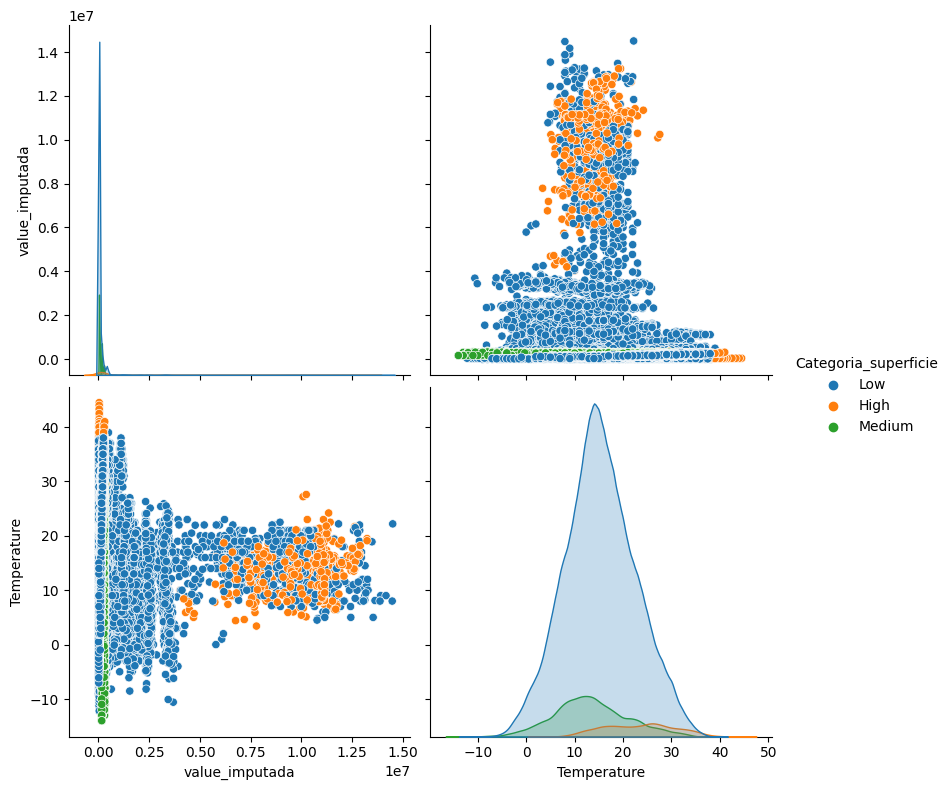

In [58]:
sns.pairplot(energy_data_pandas, hue='Categoria_superficie', height = 4, vars= ['value_imputada', 'Temperature'])

plt.show()

/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

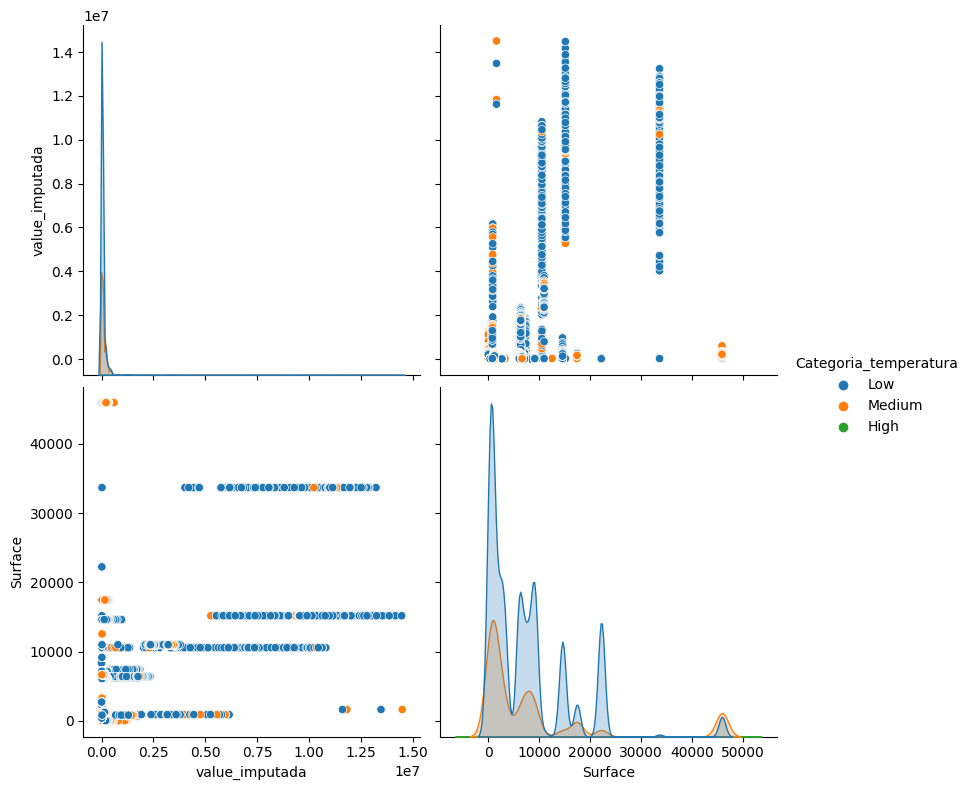

In [60]:
sns.pairplot(energy_data_pandas, hue='Categoria_temperatura', height = 4, vars= ['value_imputada', 'Surface'])
plt.show()

In [65]:
scaler = MinMaxScaler()
scaler.fit(energy_data_pandas[['value_imputada', 'Temperature', 'Surface']])
energy_data_pandas[['value_imputada', 'Temperature', 'Surface']] = scaler.transform(energy_data_pandas[['value_imputada', 'Temperature', 'Surface']])
energy_data_pandas


,SiteId,Temperature,Surface,value_imputada,Categoria_superficie,Categoria_temperatura
0,26,0.427350,0.00000,0.025318,Low,Low
1,26,0.409402,0.00000,0.026223,Low,Low
2,26,0.399145,0.00000,0.025485,Low,Low
3,26,0.393162,0.00000,0.024596,Low,Low
4,26,0.461538,0.00000,0.030383,Low,Low
...,...,...,...,...,...,...
461652,47,0.358974,0.01746,0.088933,Low,Low
461653,47,0.376068,0.01746,0.081226,Low,Low
461654,47,0.307692,0.01746,0.075054,Low,Low
461655,47,0.358974,0.01746,0.065629,Low,Low


# Modelado

In [ ]:
from sklearn.cluster import KMeans

In [105]:
energy_data_pandas_cluster = energy_data_pandas[['Temperature', 'Surface', 'value_imputada']]

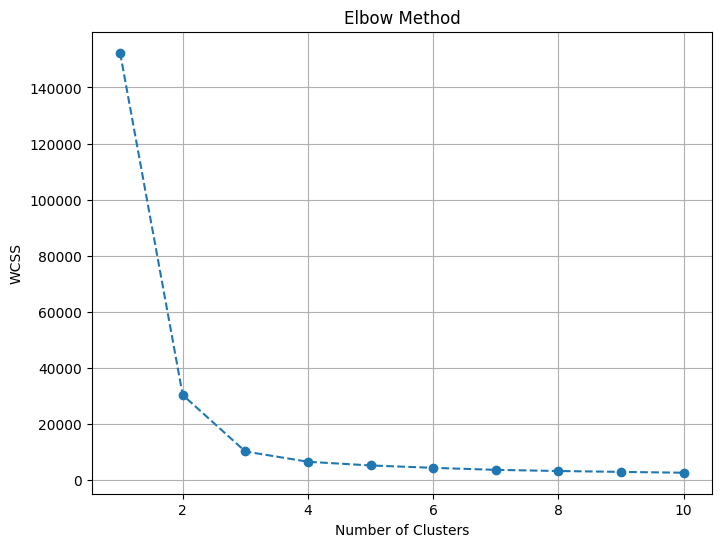

In [109]:
# Assuming you have your data in a variable named 'data'
wcss = []  # Within-Cluster Sum of Squares

# Calculate WCSS for a range of cluster numbers
for i in range(1, 11):  # Try different numbers of clusters, e.g., from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(energy_data_pandas_cluster)  # Fit the K-Means model to your data
    wcss.append(kmeans.inertia_)  # Inertia is another name for WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [110]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(energy_data_pandas_cluster)

/tmp/ipykernel_52660/68895316.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_data_pandas_cluster['Cluster'] = kmeans.labels_


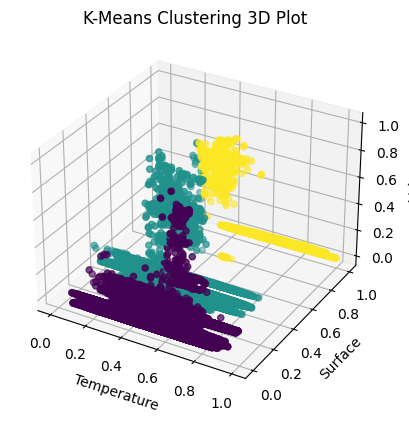

In [111]:

from mpl_toolkits.mplot3d import Axes3D  # Import the 3D toolkit


# Add the cluster labels to your DataFrame
energy_data_pandas_cluster['Cluster'] = kmeans.labels_

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the X, Y, and Z axes using your column names
x = energy_data_pandas_cluster['Temperature']
y = energy_data_pandas_cluster['Surface']
z = energy_data_pandas_cluster['value_imputada']

# Scatter plot with cluster coloring
ax.scatter(x, y, z, c=energy_data_pandas_cluster['Cluster'], cmap='viridis')

# Set axis labels
ax.set_xlabel('Temperature')
ax.set_ylabel('Surface')
ax.set_zlabel('Value')

# Set the title
plt.title('K-Means Clustering 3D Plot')

# Show the 3D plot
plt.show()
